# $k$-means Clustering

## Introduction

$k$-means clustering is a classical problem in data science. It consists in finding a partition of a given set of observations into a given number of clusters.

![Example](data.png "Before k_means")

<div style="text-align: center;">
    <img src="arrow.png" alt="Arrow" style="width: 100px; height: auto; margin-left: -150px;">
</div>

![Example](clusterdata.png "After k_means")


## Notebook installation requirements 

In [ ]:
import subprocess
import sys


def install_requirements():
    try:
        with open("requirements.txt") as f:
            packages = f.read().splitlines()
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", "-r", "requirements.txt"]
        )
        print("All packages have been successfully installed.")
    except Exception as e:
        print(f"An error occurred while installing the packages: {e}")


install_requirements()

## Problem description

**Inputs**
* $N$ observations with their coordinates $X_i$, $i = 1, \dots, N$ in the considered space
* A number of clusters to build $K$.

**Problem**: partition the $N$ observations into $K$ clusters such that each observations belongs to exactly one cluster.

**Objective**: minimize the total sum of euclidean distances between each observation and the center of its cluster

$$
\min \sum_{k=1}^K \sum_{i \in \mathrm{cluster_k}} \| X_i - c_k \|^2_2
$$
with $c_k$ the coordinates of the center of cluster $k$.

## Resolution with Scikit-learn

$k$-means clustering being a classical problem in data science, algorithms to solve it are already available. For example, in Python, Scikit-learn offers an algorithm to solve $k$-means clustering problems.

First, let's generate some data:

In [28]:
import pandas as pd
import numpy as np

data = pd.read_csv("kmeans.csv")
print(data)

             X          Y
0     2.072345  -3.241693
1    17.936710  15.784810
2     1.083576   7.319176
3    11.120670  14.406780
4    23.711550   2.557729
..         ...        ...
295  12.731310   7.050802
296   8.388222  23.453470
297  23.427080   4.598641
298   4.046104   7.634936
299   7.667025   3.193633

[300 rows x 2 columns]


In [29]:
X = data["X"].values
Y = data["Y"].values
observations_positions = np.array(list(zip(X, Y)))
nb_observations = len(observations_positions)
nb_clusters = 3

Let's plot this data:

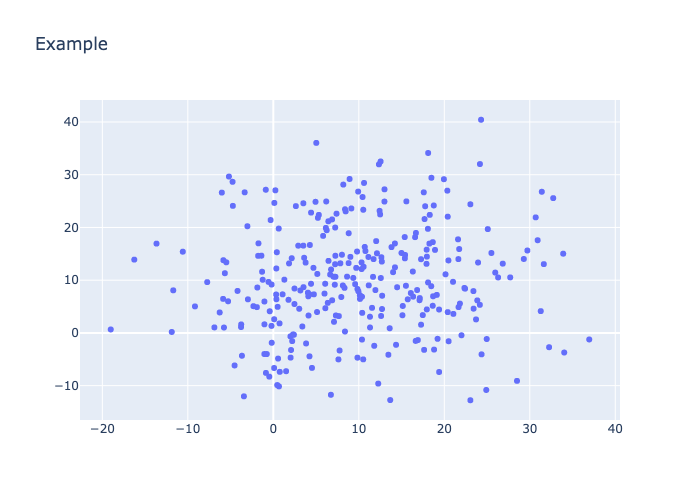

In [30]:
import plotly.graph_objects as go


def draw_data(observations_positions, name):
    nb_observations = len(observations_positions)
    fig = go.Figure()
    fig.add_scatter(
        x=[observations_positions[i][0] for i in range(nb_observations)],
        y=[observations_positions[i][1] for i in range(nb_observations)],
        mode="markers",
        name="Observations",
    )
    fig.update_layout(
        title=name,
    )
    fig.show("png")


draw_data(observations_positions, "Example")

Now, let's, solve the problem using the algorithm from Scikit-learn:

In [31]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit(observations_positions)

Let's visualize the solution:

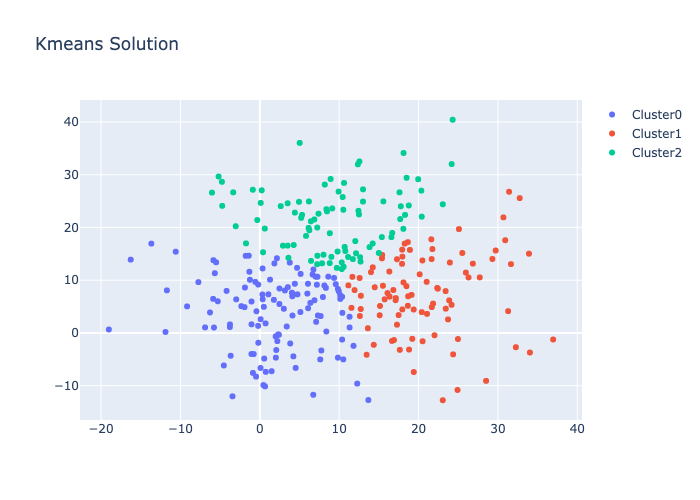

Total cost (which is the total sum of euclidean distances between each observation and the center of its cluster): 26243.629644406094


In [32]:
fig_sk = go.Figure()
for j in range(nb_clusters):
    fig_sk.add_scatter(
        x=[
            observations_positions[i][0]
            for i in range(nb_observations)
            if (kmeans.labels_[i] == j)
        ],
        y=[
            observations_positions[i][1]
            for i in range(nb_observations)
            if (kmeans.labels_[i] == j)
        ],
        mode="markers",
        name=f"Cluster{j}",
    )

fig_sk.update_layout(
    title="Kmeans Solution",
)

fig_sk.show("png")
print(
    f"Total cost (which is the total sum of euclidean distances between each observation and the center of its cluster): {kmeans.inertia_}"
)

## Mathematical model
Now, we show how to model the $k$-means clustering problem using nonlinear programming.

Variables:

* $a^k_i \in \{ 0 , 1\}$,  $i = 1, \dots, N$, $k = 1, \dots, K$: a boolean variable which is 1 if the observation $i$ is in cluster $k$: else 0 .
* $d^k_i \in \mathbb{R^+}$, $i = 1, \dots, N$, $k = 1, \dots, K$: a positive variable which represents the euclidian squared distance between observation i and cluster k.
* $c^k \in \mathbb{R^2}$,  $k = 1, \dots, K$: position of the barycenter of the cluster k. 

Objective:
$$
\min \sum_{i=1}^N{\sum_{k=1}^K}{a^k_id^k_i}
$$

Constraints:
* Each observation has to be in one cluster
$$
\forall i = 1, \dots, N \qquad\sum_{k=1}^K{a^k_i}= 1
$$

* Coordinates of the barycenter of the clusters
$$
\forall k = 1, \dots, K \qquad c_k\sum_{i=1}^N{a^k_i} = \sum_{i=1}^N{X_i}a^k_i 
$$

* Square distance formula
$$
\forall i = 1, \dots, N, \forall k = 1, \dots, K, \qquad d^k_i = \| X_i - c_k \|^2_2
$$

# Implementation with amplpy

Now, let's write the model with [amplpy](https://amplpy.ampl.com/).


In [33]:
%%writefile model.mod
########
# Sets #
########

set N;
set K;

##############
# Parameters #
##############

param positions{N, {"X", "Y"}};  # Observation positions (x, y coordinates)

#############
# Variables #
#############

var a{N, K} binary;
var cx{K};
var cy{K};
var d{s in N, t in K} = (positions[s,"X"] - cx[t])^2 + (positions[s,"Y"] - cy[t])^2;

#############
# Objective #
#############

# Objective: Minimize total distance
minimize total_distance:
    sum {s in N, t in K} a[s,t] * d[s,t];

###############
# Constraints #
###############

# Each observation is assigned to exactly one cluster
subject to one_cluster_rule {i in N}:
    sum {j in K} a[i,j] = 1;

# Barycenter x-coordinate position
subject to barycenter_x_position_rule {j in K}:
    sum {i in N} a[i,j] * positions[i,"X"] = cx[j] * sum {i in N} a[i,j];

# Barycenter y-coordinate position
subject to barycenter_y_position_rule {j in K}:
    sum {i in N} a[i,j] * positions[i,"Y"] = cy[j] * sum {i in N} a[i,j];

Overwriting model.mod


In [34]:
from amplpy import AMPL


def build_model(nb_observations, nb_clusters, data):
    ampl = AMPL()
    ampl.read("model.mod")
    ampl.set["N"] = range(nb_observations)
    ampl.set["K"] = range(nb_clusters)
    ampl.param["positions"] = data
    return ampl


ampl = build_model(nb_observations, nb_clusters, data)
ampl.solve(solver="knitro", verbose=True)

Artelys Knitro 14.0.0: 
          Commercial License
         Artelys Knitro 14.0.0

No start point provided -- Knitro computing one.

         The Knitro mixed integer solver is designed for convex problems.
         For non-convex problems it is only a heuristic, and the reported
         bounds and optimality claims cannot be verified.

concurrent_evals:        0
datacheck:               0
hessian_no_f:            1
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_rootalg from AUTO to 1.
Knitro changing mip_lpalg from AUTO to 3.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule from AUTO to 2.
Knitro changing mip_mir from AUTO to 2.
Knitro changing mip_clique from AUTO to 0.
Knitro changing mip_zerohalf from AUTO to 0.
Knitro changing mip_liftproject from AUTO to 0.
Knitro changing mip_knapsack from AUTO to 2.
Knitro changing mip_gomory from AUTO to 0.
Knitro changing mip_cut_flowcover from AUTO to 2.
Knitro changing mip_cut_probing from AUT

# Comparison with Scikit-learn

Let's visualize the solution and compare it with the classic Kmeans Algorithm.

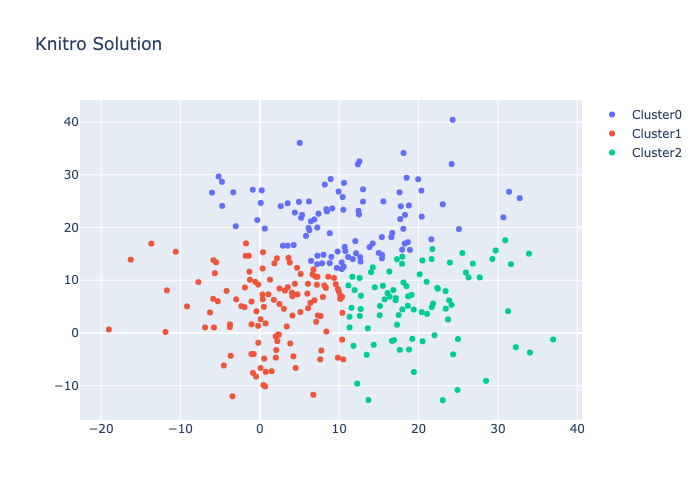

Cluster 0 contains 97 observations
Cluster 1 contains 118 observations
Cluster 2 contains 85 observations
Total cost is 26233.600250857016


In [35]:
def draw_figure(nb_observations, nb_clusters, ampl, name):
    solution = ampl.get_solution(flat=False, zeros=True)
    fig = go.Figure()
    for k in range(nb_clusters):
        fig.add_scatter(
            x=[
                observations_positions[i][0]
                for i in range(nb_observations)
                if (solution["a"][i, k] > 0.99)
            ],
            y=[
                observations_positions[i][1]
                for i in range(nb_observations)
                if (solution["a"][i, k] > 0.99)
            ],
            mode="markers",
            name=f"Cluster{k}",
        )
    fig.update_layout(
        title=name,
    )
    fig.show("png")

    for k in range(nb_clusters):
        total = 0
        for i in range(nb_observations):
            if solution["a"][i, k] > 0.99:
                total += 1
        print(f"Cluster {k} contains {total} observations")

    print(f"Total cost is {ampl.get_value('total_distance')}")


draw_figure(nb_observations, nb_clusters, ampl, "Knitro Solution")

Nonlinear programming is significantly slower than the algorithm implemented in Sciki-learn. However, it finds a better solution ($26235.01 < 26243.6$) on the considered instance.

In the next section, we will see that another advantage of nonlinear programming is when additional constraints need to be taken into account.

# Model Extensions

In some cases, additional constraints must be taken into account. These extensions are usually not supported by the algorithms available in the data science libraries. Here we illustrate 3 of these additional constraints and how to model them with nonlinear programming:
* Force some pairs of observations to be in the same cluster
* Force some pairs of observations to be in different clusters
* Impose a minimum and maximum sizes for clusters

## Cannot-link and must-link observations

### Problem description

In some cases, some pairs of observations might be known to belong to the same cluster or to different clusters. These are called "must-link" and "cannot-link" constraints.

Let $P^\text{must}$ be the set of set of observations that must belong to the same cluster.

Let $P^\text{cannot}$ be the set of pairs of observations that must belong to different clusters.

### Input data

The input data of observations is the same as for the previous example. We just need to specify must-link observations or cannot-link observations (between two observations which should not be linked)

#### Must-link observations

In [36]:
must_link_g1 = []
must_link_g2 = []
cannot_link = []

for k in range(nb_observations):
    if 0 < observations_positions[k][0] < 10 and observations_positions[k][1] >= 20:
        must_link_g1.append(k)
    if 10 < observations_positions[k][0] < 20 and observations_positions[k][1] >= 20:
        must_link_g2.append(k)
    if (
        observations_positions[k][0] == 8.9204
        or observations_positions[k][0] == 10.61132
    ):
        cannot_link.append(k)
print(cannot_link)

[22, 247]


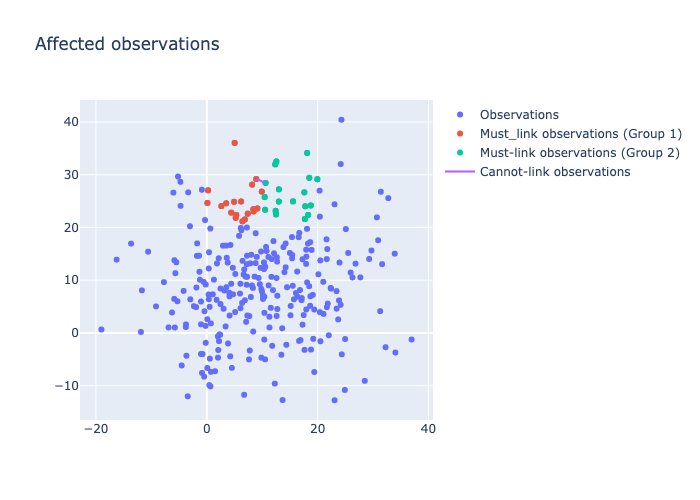

In [37]:
fig = go.Figure()
fig.add_scatter(
    x=[observations_positions[i][0] for i in range(nb_observations)],
    y=[observations_positions[i][1] for i in range(nb_observations)],
    mode="markers",
    name="Observations",
)
fig.add_scatter(
    x=[observations_positions[i][0] for i in must_link_g1],
    y=[observations_positions[i][1] for i in must_link_g1],
    mode="markers",
    name="Must_link observations (Group 1)",
)
fig.add_scatter(
    x=[observations_positions[i][0] for i in must_link_g2],
    y=[observations_positions[i][1] for i in must_link_g2],
    mode="markers",
    name="Must-link observations (Group 2)",
)
fig.add_scatter(
    x=[observations_positions[i][0] for i in cannot_link],
    y=[observations_positions[i][1] for i in cannot_link],
    mode="lines",
    name="Cannot-link observations",
)
fig.update_layout(
    title="Affected observations",
)
fig.show("png")

All red/green elements should be in the same cluster. Moreover, the linked observations should not be in the same cluster.

### Mathematical model

We add the two following set of constraints to the previous mathematical model.

* Must-link constraints

$$
\forall k = 1, \dots, K, \quad \forall S \in P^\text{must}, \quad \forall i \in S, \qquad a^k_{i} = a^k_{S[0]} 
$$

* Cannot-link constraints

$$
\forall k = 1, \dots, K, \quad \forall i_1, i_2 \in P^\text{cannot}, \qquad a^k_{i_1} + a^k_{i_2} \leq 1
$$

### Implementation with amplpy

In [38]:
%%writefile linkconstraints.mod
# Sets for must-link and cannot-link constraints
set MLG1 ordered;  # Must-link group 1
set MLG2 ordered;  # Must-link group 2
set CL;    # Cannot-link set

# Constraint: Cannot-link rule
subject to cannot_link_rule {i in CL, p in CL, j in K: i != p}:
    a[i,j] + a[p,j] <= 1;

# Constraint: Must-link group 1
subject to must_link_rule_g1 {i in MLG1, j in K}:
    a[i,j] = a[first(MLG1), j];   # The first element in AMPL is indexed as 1 (not 0)

# Constraint: Must-link group 2
subject to must_link_rule_g2 {i in MLG2, j in K}:
    a[i,j] = a[first(MLG2), j];   # The first element in AMPL is indexed as 1 (not 0)


Overwriting linkconstraints.mod


In [39]:
ampl = build_model(nb_observations, nb_clusters, data)
ampl.read("linkconstraints.mod")
ampl.set["MLG1"] = must_link_g1
ampl.set["MLG2"] = must_link_g2
ampl.set["CL"] = cannot_link
ampl.solve(solver="knitro", verbose=True)

Artelys Knitro 14.0.0: 
          Commercial License
         Artelys Knitro 14.0.0

No start point provided -- Knitro computing one.

         The Knitro mixed integer solver is designed for convex problems.
         For non-convex problems it is only a heuristic, and the reported
         bounds and optimality claims cannot be verified.

concurrent_evals:        0
datacheck:               0
hessian_no_f:            1
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_rootalg from AUTO to 1.
Knitro changing mip_lpalg from AUTO to 3.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule from AUTO to 2.
Knitro changing mip_mir from AUTO to 2.
Knitro changing mip_clique from AUTO to 0.
Knitro changing mip_zerohalf from AUTO to 0.
Knitro changing mip_liftproject from AUTO to 0.
Knitro changing mip_knapsack from AUTO to 2.
Knitro changing mip_gomory from AUTO to 0.
Knitro changing mip_cut_flowcover from AUTO to 2.
Knitro changing mip_cut_probing from AUT

### Output visualization

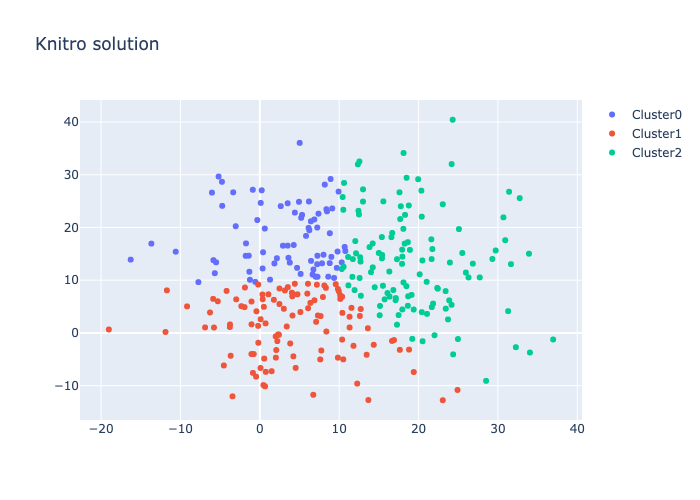

Cluster 0 contains 76 observations
Cluster 1 contains 108 observations
Cluster 2 contains 116 observations
Total cost is 29284.148904670987


In [40]:
draw_figure(nb_observations, nb_clusters, ampl, "Knitro solution")

## Constrained clustering

### Problem description

Another common case in clustering is to have lower and/or upper bounds on the cluster sizes. This is known as "constrained clustering".

Let $u_{limit} \in \mathbb{R^+}$ be the maximum number of observations in a cluster.

Let $l_{limit} \in \mathbb{R^+}$ be the minimum number of observations in a cluster.

### Input data
To illustrate this, we are going to use some new observations from the `kmeans2.csv` file.
We look to partition these observations into 10 clusters such that the size of each cluster lies between 8 and 12. 

In [41]:
data = pd.read_csv("kmeans2.csv")
print(data)

            X          Y
0    2.072345  -3.241693
1   17.936710  15.784810
2    1.083576   7.319176
3   11.120670  14.406780
4   23.711550   2.557729
..        ...        ...
85   5.987025   7.456533
86  12.639020  14.350810
87   7.392535  22.613040
88  10.372120  -1.258270
89 -19.017910   0.650730

[90 rows x 2 columns]


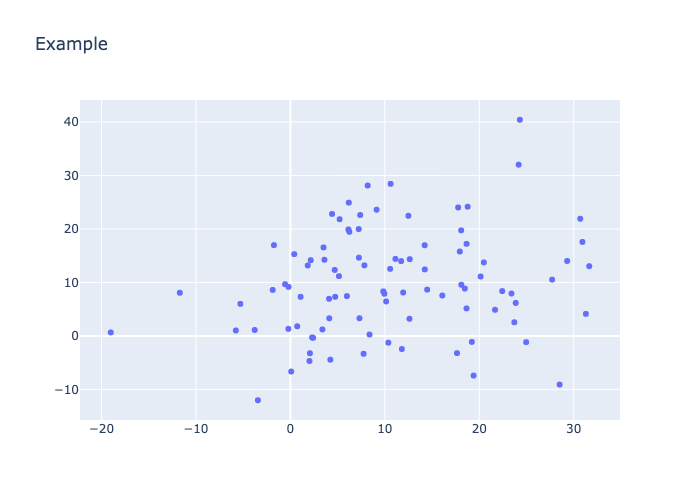

In [42]:
X = data["X"].values
Y = data["Y"].values
observations_positions = np.array(list(zip(X, Y)))
nb_observations = len(observations_positions)
nb_clusters = 10
draw_data(observations_positions, "Example")

### Resolution without bounds on cluster sizes

Let's solve the problem using the model defined in the previous section. 

In [43]:
ampl = build_model(nb_observations, nb_clusters, data)
ampl.solve(solver="knitro", verbose=True)

Artelys Knitro 14.0.0: 
          Commercial License
         Artelys Knitro 14.0.0

No start point provided -- Knitro computing one.

         The Knitro mixed integer solver is designed for convex problems.
         For non-convex problems it is only a heuristic, and the reported
         bounds and optimality claims cannot be verified.

concurrent_evals:        0
datacheck:               0
hessian_no_f:            1
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_rootalg from AUTO to 1.
Knitro changing mip_lpalg from AUTO to 3.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule from AUTO to 2.
Knitro changing mip_mir from AUTO to 2.
Knitro changing mip_clique from AUTO to 0.
Knitro changing mip_zerohalf from AUTO to 0.
Knitro changing mip_liftproject from AUTO to 0.
Knitro changing mip_knapsack from AUTO to 2.
Knitro changing mip_gomory from AUTO to 0.
Knitro changing mip_cut_flowcover from AUTO to 2.
Knitro changing mip_cut_probing from AUT

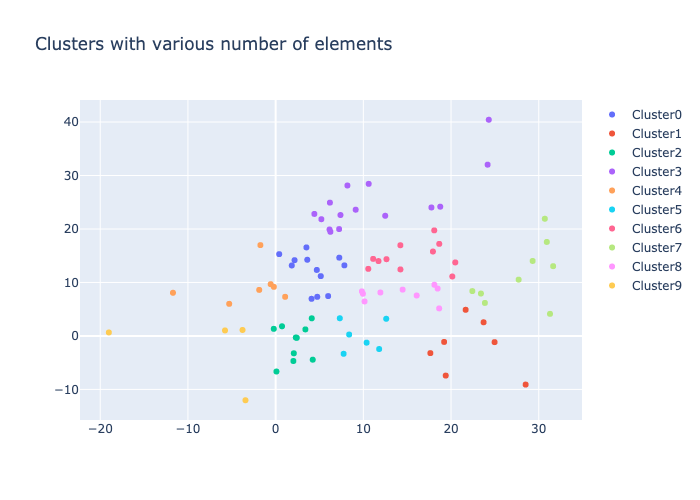

Cluster 0 contains 12 observations
Cluster 1 contains 7 observations
Cluster 2 contains 10 observations
Cluster 3 contains 15 observations
Cluster 4 contains 7 observations
Cluster 5 contains 6 observations
Cluster 6 contains 11 observations
Cluster 7 contains 9 observations
Cluster 8 contains 9 observations
Cluster 9 contains 4 observations
Total cost is 2842.27310543285


In [44]:
draw_figure(
    nb_observations, nb_clusters, ampl, "Clusters with various number of elements"
)

In this case, some clusters have less observations (or more observations) than required. We need to add new constraints to the model in order to take into account the limits on the number of observations in each cluster.

### Mathematical formulation

We add the two following set of constraints to the previous mathematical model.

* Cluster size upper bound

$$
\forall k = 1, \dots, K, \qquad \sum_{i=1}^N {a^k_i} \leq u_{limit}
$$

* Cluster size lower bound

$$
\forall k = 1, \dots, K, \qquad \sum_{i=1}^N {a^k_i} \geq l_{limit}
$$

### Implementation with amplpy

In [45]:
%%writefile clustersizes.mod
# Constraint: Upper bound on cluster size
subject to size_upper_clusters_rule {j in K}:
    sum {i in N} a[i,j] <= 12;

# Constraint: Lower bound on cluster size
subject to size_lower_clusters_rule {j in K}:
    sum {i in N} a[i,j] >= 8;

Overwriting clustersizes.mod


In [46]:
ampl = build_model(nb_observations, nb_clusters, data)
ampl.read("clustersizes.mod")
ampl.solve(solver="knitro", verbose=True)

Artelys Knitro 14.0.0: 
          Commercial License
         Artelys Knitro 14.0.0

No start point provided -- Knitro computing one.

         The Knitro mixed integer solver is designed for convex problems.
         For non-convex problems it is only a heuristic, and the reported
         bounds and optimality claims cannot be verified.

concurrent_evals:        0
datacheck:               0
hessian_no_f:            1
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_rootalg from AUTO to 1.
Knitro changing mip_lpalg from AUTO to 3.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule from AUTO to 2.
Knitro changing mip_mir from AUTO to 2.
Knitro changing mip_clique from AUTO to 0.
Knitro changing mip_zerohalf from AUTO to 0.
Knitro changing mip_liftproject from AUTO to 0.
Knitro changing mip_knapsack from AUTO to 2.
Knitro changing mip_gomory from AUTO to 0.
Knitro changing mip_cut_flowcover from AUTO to 2.
Knitro changing mip_cut_probing from AUT

### Output visualization

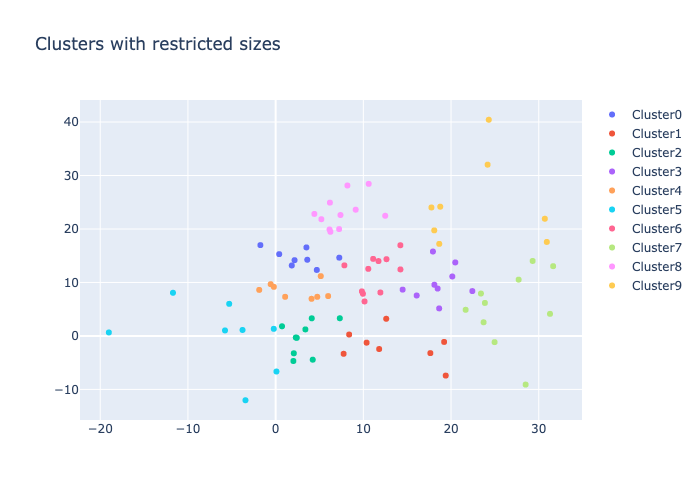

Cluster 0 contains 8 observations
Cluster 1 contains 8 observations
Cluster 2 contains 9 observations
Cluster 3 contains 9 observations
Cluster 4 contains 8 observations
Cluster 5 contains 8 observations
Cluster 6 contains 11 observations
Cluster 7 contains 10 observations
Cluster 8 contains 11 observations
Cluster 9 contains 8 observations
Total cost is 2687.480121999701


In [47]:
draw_figure(nb_observations, nb_clusters, ampl, "Clusters with restricted sizes")

The constraints are satisfied, we can observe that each cluster has a number of observations between 8 and 12. 